In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

Data Preprocessing

In [17]:
df = pd.read_csv("london_merged.csv") 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [19]:
target_variable = ['cnt']
float_variables = ['t1','t2','hum','wind_speed']
one_hot_variables = ['weather_code','is_holiday','is_weekend','season']

In [20]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [21]:
df.columns

Index(['timestamp', 'cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code',
       'is_holiday', 'is_weekend', 'season'],
      dtype='object')

In [22]:
df["year"] = df['timestamp'].dt.year
df["month"] = df['timestamp'].dt.month
df["day_of_month"] = df['timestamp'].dt.day
df["day_of_week"] = df['timestamp'].dt.weekday
df["hour"] = df['timestamp'].dt.hour

In [23]:
df['date_year']  = df[[ 'year', 'month','day_of_month']].astype(str).apply(lambda x: '-'.join(x), axis=1)
print('sum cnt before',df['cnt'].sum())
print('mean hum before',df['hum'].mean())
print('mean t1 before',df['t1'].mean())
print('mean t2 before',df['t2'].mean())

df1 = df.groupby('date_year').agg({'cnt':'sum','t1':'mean','t2':'mean','hum':'mean','wind_speed':'mean','weather_code':pd.Series.mode,'is_holiday':'first','is_weekend':'first','season':'first','year':'first','month':'first','day_of_month':'first'})

print('sum cnt after',df1['cnt'].sum())
print('mean hum after',df1['hum'].mean())
print('mean t1 after',df1['t1'].mean())
print('mean t2 after',df1['t2'].mean())

cnt_mean =df[['cnt']].mean()
df1.reset_index(inplace=True)

sum cnt before 19905972
mean hum before 72.32495405995176
mean t1 before 12.468090808162016
mean t2 before 11.52083572604418
sum cnt after 19905972
mean hum after 72.30901752091482
mean t1 after 12.481400329631802
mean t2 after 11.53485811918213


In [24]:
df1['date_year'] = pd.to_datetime(df1['date_year'])
df1.sort_values('date_year',inplace=True)

In [25]:
df1[df1['year']<=2016].tail()

,date_year,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month,day_of_month
473,2016-12-27,10842,4.187500,2.458333,81.916667,7.500000,1,1.0,0.0,3.0,2016,12,27
474,2016-12-28,12428,2.166667,0.020833,97.229167,7.395833,1,0.0,0.0,3.0,2016,12,28
475,2016-12-29,14052,3.770833,2.437500,89.979167,6.062500,1,0.0,0.0,3.0,2016,12,29
477,2016-12-30,11566,3.270833,1.062500,98.687500,9.000000,4,0.0,0.0,3.0,2016,12,30
478,2016-12-31,11424,7.437500,5.041667,90.958333,13.312500,4,0.0,1.0,3.0,2016,12,31


In [30]:
df1.set_index('date_year',inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FE5101FA90>,
      dtype=object)

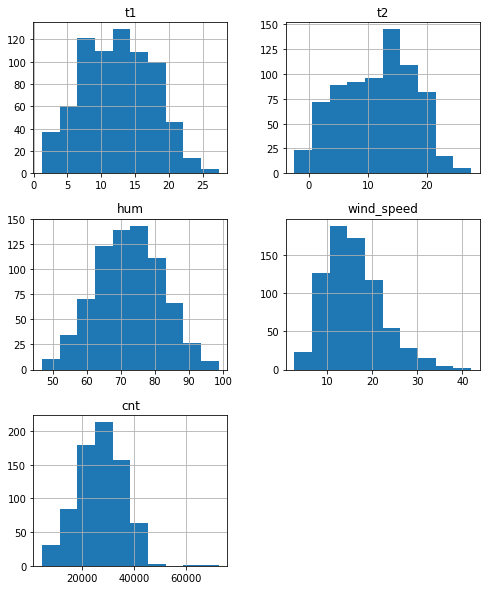

In [31]:
df1[float_variables+target_variable].hist(figsize=(8,10))

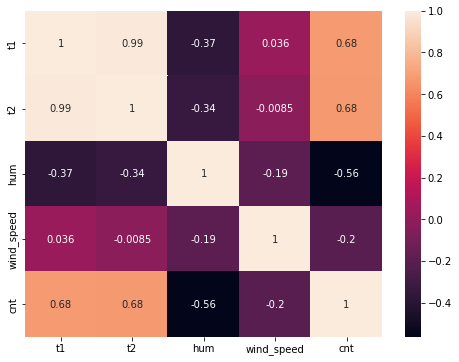

In [32]:
plt.figure(figsize=(8,6))
sns.heatmap(df1[float_variables+target_variable].corr(),annot=True)

Text(0,0.5,'temp')

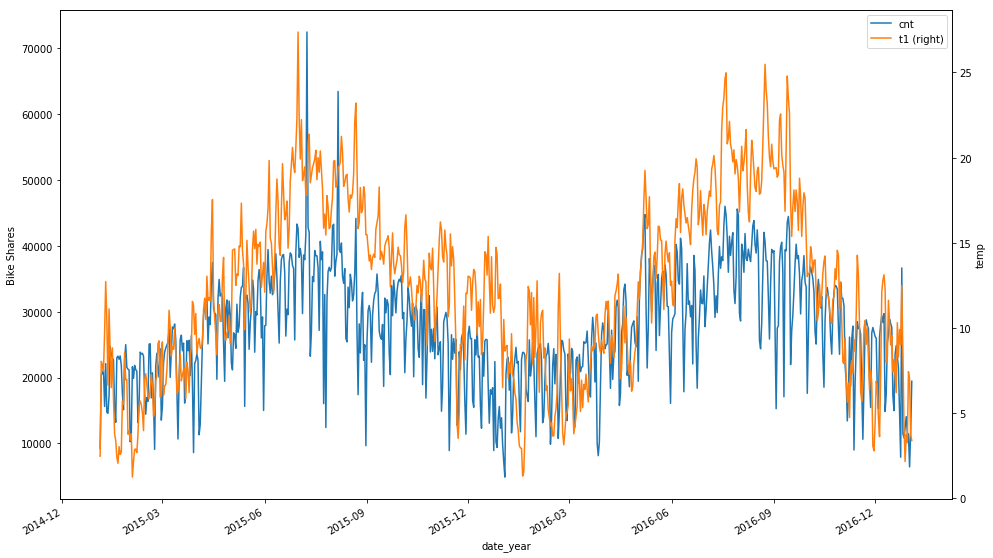

In [33]:
ax = df1[['cnt','t1']].plot(figsize=(16,10),ylabel='Bike Shares',secondary_y = 't1')
ax.right_ax.set_ylabel('temp')


Text(0,0.5,'hum')

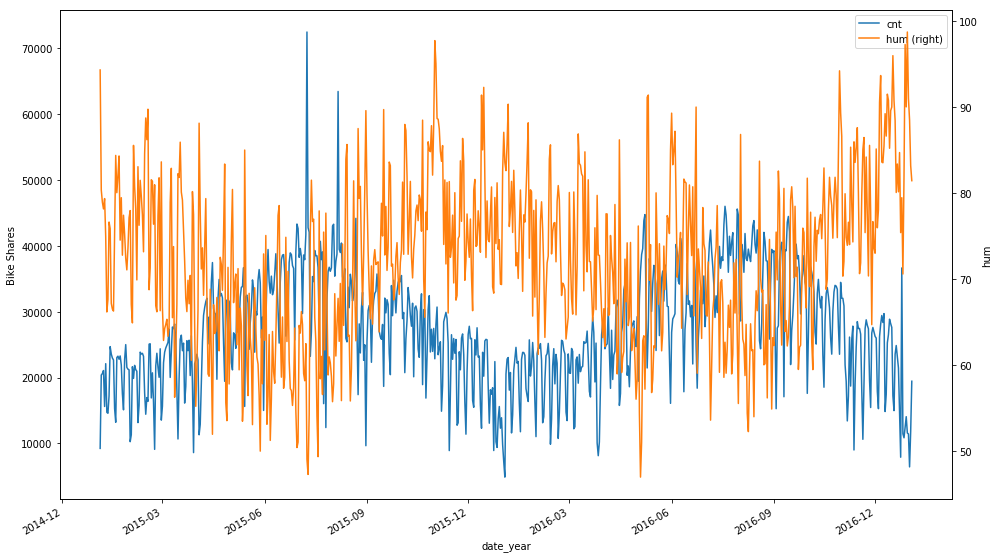

In [34]:
ax = df1[['cnt','hum']].plot(figsize=(16,10),ylabel='Bike Shares',secondary_y = 'hum')
ax.right_ax.set_ylabel('hum')

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [37]:
df1.reset_index(inplace=True)
cnt_mean =df1[['cnt']].mean()

In [38]:
sc = MinMaxScaler()
y = df1[target_variable]
cnt_mean =df1[['cnt']].mean()
df1[['cnt','hum','t1']] = pd.DataFrame(sc.fit_transform(df1[['cnt','hum','t1']]),columns=['cnt','hum','t1'])

#df1['weather_code'] = df1['weather_code'].astype('str')
#df1['season'] = df1['season'].astype('str')
#X = pd.get_dummies(df1,columns=['weather_code','season'])
#X = df1

In [39]:
X = df1[['date_year','cnt','t1','hum']]

In [40]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
df_supervised = series_to_supervised(X[['cnt','hum','t1']],30,31)

In [42]:
df_supervised.reset_index(drop=True,inplace=True)

In [43]:
df_supervised.head()

,var1(t-30),var2(t-30),var3(t-30),var1(t-29),var2(t-29),var3(t-29),var1(t-28),var2(t-28),var3(t-28),var1(t-27),...,var3(t+27),var1(t+28),var2(t+28),var3(t+28),var1(t+29),var2(t+29),var3(t+29),var1(t+30),var2(t+30),var3(t+30)
0,0.064538,0.914688,0.047049,0.229216,0.645070,0.259968,0.232779,0.617706,0.252791,0.239447,...,0.184211,0.280565,0.333602,0.204147,0.290027,0.342857,0.208134,0.296104,0.354527,0.239234
1,0.229216,0.645070,0.259968,0.232779,0.617706,0.252791,0.239447,0.602502,0.237570,0.158675,...,0.204147,0.290027,0.342857,0.208134,0.296104,0.354527,0.239234,0.302624,0.316298,0.300638
2,0.232779,0.617706,0.252791,0.239447,0.602502,0.237570,0.158675,0.625755,0.325359,0.254824,...,0.208134,0.296104,0.354527,0.239234,0.302624,0.316298,0.300638,0.332609,0.336016,0.374801
3,0.239447,0.602502,0.237570,0.158675,0.625755,0.325359,0.254824,0.539638,0.439394,0.145487,...,0.239234,0.302624,0.316298,0.300638,0.332609,0.336016,0.374801,0.223967,0.616901,0.336523
4,0.158675,0.625755,0.325359,0.254824,0.539638,0.439394,0.145487,0.371026,0.353270,0.143506,...,0.300638,0.332609,0.336016,0.374801,0.223967,0.616901,0.336523,0.283404,0.693763,0.271930


In [44]:
df_supervised_x = df_supervised.iloc[:,0:90]
df_supervised_y = df_supervised.iloc[:,90:]

In [45]:
df_supervised_y = df_supervised_y[df_supervised_y.columns[df_supervised_y.columns.str.contains(pat = 'var1')]]

In [46]:
df_supervised_y.head()

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+21),var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29),var1(t+30)
0,0.221779,0.251068,0.241458,0.237835,0.122422,0.161292,0.280757,0.276336,0.278125,0.271428,...,0.278244,0.247254,0.224248,0.288283,0.128040,0.159267,0.257101,0.280565,0.290027,0.296104
1,0.251068,0.241458,0.237835,0.122422,0.161292,0.280757,0.276336,0.278125,0.271428,0.189695,...,0.247254,0.224248,0.288283,0.128040,0.159267,0.257101,0.280565,0.290027,0.296104,0.302624
2,0.241458,0.237835,0.122422,0.161292,0.280757,0.276336,0.278125,0.271428,0.189695,0.141258,...,0.224248,0.288283,0.128040,0.159267,0.257101,0.280565,0.290027,0.296104,0.302624,0.332609
3,0.237835,0.122422,0.161292,0.280757,0.276336,0.278125,0.271428,0.189695,0.141258,0.178650,...,0.288283,0.128040,0.159267,0.257101,0.280565,0.290027,0.296104,0.302624,0.332609,0.223967
4,0.122422,0.161292,0.280757,0.276336,0.278125,0.271428,0.189695,0.141258,0.178650,0.170208,...,0.128040,0.159267,0.257101,0.280565,0.290027,0.296104,0.302624,0.332609,0.223967,0.283404


In [47]:
#df_supervised = pd.concat([df_supervised_x,df_supervised_y],axis=1)
df_supervised.shape

(670, 183)

In [48]:
df_supervised.head()

,var1(t-30),var2(t-30),var3(t-30),var1(t-29),var2(t-29),var3(t-29),var1(t-28),var2(t-28),var3(t-28),var1(t-27),...,var3(t+27),var1(t+28),var2(t+28),var3(t+28),var1(t+29),var2(t+29),var3(t+29),var1(t+30),var2(t+30),var3(t+30)
0,0.064538,0.914688,0.047049,0.229216,0.645070,0.259968,0.232779,0.617706,0.252791,0.239447,...,0.184211,0.280565,0.333602,0.204147,0.290027,0.342857,0.208134,0.296104,0.354527,0.239234
1,0.229216,0.645070,0.259968,0.232779,0.617706,0.252791,0.239447,0.602502,0.237570,0.158675,...,0.204147,0.290027,0.342857,0.208134,0.296104,0.354527,0.239234,0.302624,0.316298,0.300638
2,0.232779,0.617706,0.252791,0.239447,0.602502,0.237570,0.158675,0.625755,0.325359,0.254824,...,0.208134,0.296104,0.354527,0.239234,0.302624,0.316298,0.300638,0.332609,0.336016,0.374801
3,0.239447,0.602502,0.237570,0.158675,0.625755,0.325359,0.254824,0.539638,0.439394,0.145487,...,0.239234,0.302624,0.316298,0.300638,0.332609,0.336016,0.374801,0.223967,0.616901,0.336523
4,0.158675,0.625755,0.325359,0.254824,0.539638,0.439394,0.145487,0.371026,0.353270,0.143506,...,0.300638,0.332609,0.336016,0.374801,0.223967,0.616901,0.336523,0.283404,0.693763,0.271930


In [49]:
n_test = 151
df_train, df_test = df_supervised[0:-n_test], df_supervised[-n_test:]

LSTM model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [51]:
# reshape training into [samples, timesteps, features]
X, y = df_train.values[:, 0:30*3], df_train.values[:, 30*3:]
X = X.reshape(X.shape[0], 1, X.shape[1])
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
lstm_model = model.fit(X, y, epochs=150, batch_size=24, validation_split=0.1, shuffle=True)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 467 samples, validate on 52 samples
Epoch 1/150
467/467 [==============================] - 1s 2ms/sample - loss: 0.1416 - val_loss: 0.1057
Epoch 2/150
467/467 [==============================] - 0s 169us/sample - loss: 0.0478 - val_loss: 0.0275
Epoch 3/150
467/467 [==============================] - 0s 171us/sample - loss: 0.0241 - val_loss: 0.0233
Epoch 4/150
467/467 [==============================] - 0s 174us/sample - loss: 0.0221 - val_loss: 0.0229
Epoch 5/150
467/467 [==============================] - 0s 182us/sample - loss: 0.0208 - val_loss: 0.0220
Epoch 6/150
467/467 [==============================] - 0s 176us/sample - loss: 0.0193 - val_loss: 0.0227
Epoch 7/150
467/467 [==============================] - 0s 180us/sample - loss: 0.0179 - val_loss: 0.0221
Epoch 8/150
467/467 [==========================

467/467 [==============================] - 0s 191us/sample - loss: 0.0131 - val_loss: 0.0326
Epoch 72/150
467/467 [==============================] - 0s 174us/sample - loss: 0.0131 - val_loss: 0.0341
Epoch 73/150
467/467 [==============================] - 0s 182us/sample - loss: 0.0130 - val_loss: 0.0325
Epoch 74/150
467/467 [==============================] - 0s 236us/sample - loss: 0.0130 - val_loss: 0.0341
Epoch 75/150
467/467 [==============================] - 0s 216us/sample - loss: 0.0129 - val_loss: 0.0342
Epoch 76/150
467/467 [==============================] - 0s 199us/sample - loss: 0.0130 - val_loss: 0.0340
Epoch 77/150
467/467 [==============================] - 0s 159us/sample - loss: 0.0129 - val_loss: 0.0336
Epoch 78/150
467/467 [==============================] - 0s 694us/sample - loss: 0.0129 - val_loss: 0.0325
Epoch 79/150
467/467 [==============================] - 0s 671us/sample - loss: 0.0129 - val_loss: 0.0338
Epoch 80/150
467/467 [==============================] - 0s 

Epoch 148/150
467/467 [==============================] - 0s 651us/sample - loss: 0.0117 - val_loss: 0.0385
Epoch 149/150
467/467 [==============================] - 0s 619us/sample - loss: 0.0117 - val_loss: 0.0402
Epoch 150/150
467/467 [==============================] - 0s 557us/sample - loss: 0.0117 - val_loss: 0.0385


In [52]:
df_test.head()

,var1(t-30),var2(t-30),var3(t-30),var1(t-29),var2(t-29),var3(t-29),var1(t-28),var2(t-28),var3(t-28),var1(t-27),...,var3(t+27),var1(t+28),var2(t+28),var3(t+28),var1(t+29),var2(t+29),var3(t+29),var1(t+30),var2(t+30),var3(t+30)
519,0.505374,0.449095,0.560606,0.440704,0.488531,0.622010,0.433607,0.509457,0.659490,0.536645,...,0.673844,0.523383,0.400402,0.743222,0.505848,0.309859,0.688198,0.460146,0.298487,0.705222
520,0.440704,0.488531,0.622010,0.433607,0.509457,0.659490,0.536645,0.549698,0.549442,0.514053,...,0.743222,0.505848,0.309859,0.688198,0.460146,0.298487,0.705222,0.547291,0.228169,0.736842
521,0.433607,0.509457,0.659490,0.536645,0.549698,0.549442,0.514053,0.334406,0.627592,0.351283,...,0.688198,0.460146,0.298487,0.705222,0.547291,0.228169,0.736842,0.490974,0.343260,0.780702
522,0.536645,0.549698,0.549442,0.514053,0.334406,0.627592,0.351283,0.513481,0.647528,0.191794,...,0.705222,0.547291,0.228169,0.736842,0.490974,0.343260,0.780702,0.486435,0.143260,0.654705
523,0.514053,0.334406,0.627592,0.351283,0.513481,0.647528,0.191794,0.669618,0.610845,0.331544,...,0.736842,0.490974,0.343260,0.780702,0.486435,0.143260,0.654705,0.512235,0.102213,0.593301


In [53]:
df_test1 = df_test.values[:,0:30*3]
df_test2 = df_test1.reshape(df_test1.shape[0], 1, df_test1.shape[1])
df_test_y = df_test.values[:,30*3:]

In [54]:
df_test_y.shape

(151, 93)

In [55]:
forecasts = model.predict(df_test2, batch_size=1)

In [56]:
from sklearn.metrics import mean_squared_error
cnt_actuals = np.dot(df_test_y[150][0:93:3].reshape(31,1),cnt_mean)
df_actuals = pd.DataFrame()
df_actuals['actuals'] = cnt_actuals

In [57]:
df_actuals

,actuals
0,4192.169630
1,8612.533915
2,9364.044224
3,9899.858172
4,9473.303501
5,10016.777695
6,4016.790347
7,5072.291414
8,8227.102662
9,8729.050266


In [58]:
def evaluate_forecast(df,cnt_average,predictions, forecast_column):
    final_df = df
    cnt_forecast = predictions[150][0:93:3]
    cnt1f = cnt_forecast.reshape(31,1)
    cnt2f = np.dot(cnt1f,cnt_average)
    final_df[forecast_column] = cnt2f
    final_df[final_df < 0] = 0
    print(forecast_column+'_mse:',mean_squared_error(df_test_y,predictions))
    return final_df

In [59]:
df_pred = evaluate_forecast(df_actuals,cnt_mean,forecasts,'LSTM_prediction')

LSTM_prediction_mse: 0.02142800126760858


In [60]:
df_pred

,actuals,LSTM_prediction
0,4192.169630,4740.535127
1,8612.533915,5326.055364
2,9364.044224,7515.009420
3,9899.858172,8079.135077
4,9473.303501,8002.694344
5,10016.777695,6065.603736
6,4016.790347,3905.223327
7,5072.291414,2987.082854
8,8227.102662,5516.732988
9,8729.050266,7510.981861


XGBoost model

In [61]:
from xgboost.sklearn import XGBRegressor

In [62]:
xgbmodel = XGBRegressor()
xgbmodel.fit(df_train.values[:, 0:30*3],df_train.values[:, 30*3:])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
       early_stopping_rounds=None, enable_categorical=False,
       eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
       importance_type=None, interaction_constraints='',
       learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
       max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
       missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
       num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
       random_state=0, reg_alpha=0, reg_lambda=1,
       sampling_method='uniform', scale_pos_weight=1, subsample=1,
       tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
preds = xgbmodel.predict(df_test1)

In [64]:
preds.shape

(151, 93)

In [65]:
df_pred1 = evaluate_forecast(df_pred,cnt_mean,preds,'XGB_prediction')

XGB_prediction_mse: 0.021330332612998656


In [66]:
df_pred1

,actuals,LSTM_prediction,XGB_prediction
0,4192.169630,4740.535127,4091.924996
1,8612.533915,5326.055364,6917.824621
2,9364.044224,7515.009420,8821.440409
3,9899.858172,8079.135077,7618.931175
4,9473.303501,8002.694344,7898.393888
5,10016.777695,6065.603736,6948.688760
6,4016.790347,3905.223327,5180.997813
7,5072.291414,2987.082854,3592.244756
8,8227.102662,5516.732988,7038.852125
9,8729.050266,7510.981861,7439.886014


In [67]:
from tensorflow.keras.layers import Dropout, Bidirectional 

In [68]:
x_train, y_train = df_train.values[:, 0:30*3], df_train.values[:, 30*3:]

In [69]:
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

Bidirectional model

In [70]:
model = Sequential()
model.add(Bidirectional(LSTM(50,input_shape=(x_train.shape[1],x_train.shape[2]))))
#model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer="adam",loss="mse")


history = model.fit(x_train, y_train, epochs=150, batch_size=24, validation_split=0.1, shuffle=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 467 samples, validate on 52 samples
Epoch 1/150
467/467 [==============================] - 2s 3ms/sample - loss: 0.1003 - val_loss: 0.0334
Epoch 2/150
467/467 [==============================] - 0s 246us/sample - loss: 0.0265 - val_loss: 0.0274
Epoch 3/150
467/467 [==============================] - 0s 255us/sample - loss: 0.0214 - val_loss: 0.0216
Epoch 4/150
467/467 [==============================] - 0s 354us/sample - loss: 0.0190 - val_loss: 0.0235
Epoch 5/150
467/467 [==============================] - 0s 231us/sample - loss: 0.0175 - val_loss: 0.0217
Epoch 6/150
467/467 [==============================] - 0s 249us/sample - loss:

Epoch 68/150
467/467 [==============================] - 0s 225us/sample - loss: 0.0125 - val_loss: 0.0338
Epoch 69/150
467/467 [==============================] - 0s 214us/sample - loss: 0.0125 - val_loss: 0.0336
Epoch 70/150
467/467 [==============================] - 0s 210us/sample - loss: 0.0124 - val_loss: 0.0350
Epoch 71/150
467/467 [==============================] - 0s 219us/sample - loss: 0.0123 - val_loss: 0.0337
Epoch 72/150
467/467 [==============================] - 0s 212us/sample - loss: 0.0123 - val_loss: 0.0346
Epoch 73/150
467/467 [==============================] - 0s 210us/sample - loss: 0.0123 - val_loss: 0.0338
Epoch 74/150
467/467 [==============================] - 0s 212us/sample - loss: 0.0123 - val_loss: 0.0365
Epoch 75/150
467/467 [==============================] - 0s 214us/sample - loss: 0.0123 - val_loss: 0.0351
Epoch 76/150
467/467 [==============================] - 0s 216us/sample - loss: 0.0123 - val_loss: 0.0336
Epoch 77/150
467/467 [========================

Epoch 145/150
467/467 [==============================] - 0s 221us/sample - loss: 0.0108 - val_loss: 0.0416
Epoch 146/150
467/467 [==============================] - 0s 221us/sample - loss: 0.0107 - val_loss: 0.0400
Epoch 147/150
467/467 [==============================] - 0s 223us/sample - loss: 0.0107 - val_loss: 0.0405
Epoch 148/150
467/467 [==============================] - 0s 214us/sample - loss: 0.0107 - val_loss: 0.0405
Epoch 149/150
467/467 [==============================] - 0s 216us/sample - loss: 0.0107 - val_loss: 0.0411
Epoch 150/150
467/467 [==============================] - 0s 216us/sample - loss: 0.0106 - val_loss: 0.0413


In [71]:
y_pred = model.predict(df_test2)

In [72]:
y_pred.shape

(151, 93)

In [73]:
df_pred2 = evaluate_forecast(df_pred1,cnt_mean,y_pred,'Bidirectional_LSTM_prediction')

Bidirectional_LSTM_prediction_mse: 0.02462789313020983


In [74]:
df_pred2

,actuals,LSTM_prediction,XGB_prediction,Bidirectional_LSTM_prediction
0,4192.169630,4740.535127,4091.924996,4917.798118
1,8612.533915,5326.055364,6917.824621,5694.866341
2,9364.044224,7515.009420,8821.440409,8735.554903
3,9899.858172,8079.135077,7618.931175,8347.240820
4,9473.303501,8002.694344,7898.393888,7630.905769
5,10016.777695,6065.603736,6948.688760,6610.438798
6,4016.790347,3905.223327,5180.997813,4819.077408
7,5072.291414,2987.082854,3592.244756,4195.964181
8,8227.102662,5516.732988,7038.852125,6554.673844
9,8729.050266,7510.981861,7439.886014,7745.583122


In [79]:
df_date = df1['date_year'][-31:].reset_index()

In [80]:
df_date

,index,date_year
0,699,2016-12-04
1,700,2016-12-05
2,701,2016-12-06
3,702,2016-12-07
4,703,2016-12-08
5,704,2016-12-09
6,705,2016-12-10
7,706,2016-12-11
8,707,2016-12-12
9,708,2016-12-13


In [81]:
df_pred2['date_year'] = df_date['date_year']

In [82]:
df_pred2

,actuals,LSTM_prediction,XGB_prediction,Bidirectional_LSTM_prediction,date_year
0,4192.169630,4740.535127,4091.924996,4917.798118,2016-12-04
1,8612.533915,5326.055364,6917.824621,5694.866341,2016-12-05
2,9364.044224,7515.009420,8821.440409,8735.554903,2016-12-06
3,9899.858172,8079.135077,7618.931175,8347.240820,2016-12-07
4,9473.303501,8002.694344,7898.393888,7630.905769,2016-12-08
5,10016.777695,6065.603736,6948.688760,6610.438798,2016-12-09
6,4016.790347,3905.223327,5180.997813,4819.077408,2016-12-10
7,5072.291414,2987.082854,3592.244756,4195.964181,2016-12-11
8,8227.102662,5516.732988,7038.852125,6554.673844,2016-12-12
9,8729.050266,7510.981861,7439.886014,7745.583122,2016-12-13


In [83]:
df_pred_final = df_pred2.set_index('date_year')

In [84]:
df_pred_final

,actuals,LSTM_prediction,XGB_prediction,Bidirectional_LSTM_prediction
date_year,,,,
2016-12-04,4192.169630,4740.535127,4091.924996,4917.798118
2016-12-05,8612.533915,5326.055364,6917.824621,5694.866341
2016-12-06,9364.044224,7515.009420,8821.440409,8735.554903
2016-12-07,9899.858172,8079.135077,7618.931175,8347.240820
2016-12-08,9473.303501,8002.694344,7898.393888,7630.905769
2016-12-09,10016.777695,6065.603736,6948.688760,6610.438798
2016-12-10,4016.790347,3905.223327,5180.997813,4819.077408
2016-12-11,5072.291414,2987.082854,3592.244756,4195.964181
2016-12-12,8227.102662,5516.732988,7038.852125,6554.673844


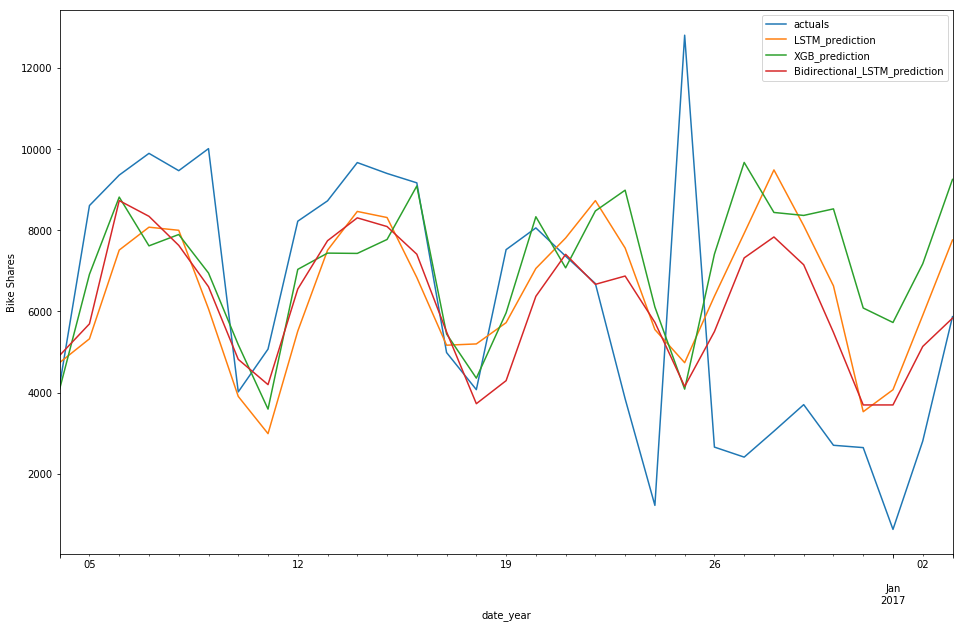

In [86]:
ax_pred = df_pred_final.plot(figsize=(16,10),ylabel='Bike Shares')
